## Feature Extraction: Neurophysiology [dyskinesia project]

This notebooks helps to extract features from preprocessed ECoG and LFP (STN electrodes) data within the ReTune-Dyskinesia project.

Data is required to be preprocessed, for example with the corresponding preprocess functions.

<b> Content </b>


<b> Periodic component analysis: </b> 
- Try Wavelet Dceomposition vs Welch (tapered) Spectral Decomposition



<b> Aperiodic estimates </b>
Relevant literature:
- Periodic and a-periodic components relevance and interaction, different reasons (per + a-per) for signal changes observed within a specific bandwidth. Aperiodic component (complicated) vs exponent (1/f) (Donoghue, ..., Shestyuk & Voytek, Nature Neurosc 2020 : https://www.nature.com/articles/s41593-020-00744-x)
- cycle-by-cycle features: bycycle toolbox (Cole & Voytek, J of Neurophys 2019, https://journals.physiology.org/doi/full/10.1152/jn.00273.2019)

### 0. Loading packages and functions, defining paths



In [1]:
# Importing Python and external packages
import os
import sys
import importlib
import json
import csv
from dataclasses import dataclass, field, fields
from collections import namedtuple
from typing import Any
from itertools import compress
from pathlib import Path
import pandas as pd
import numpy as np
import sklearn as sk
from scipy.stats import pearsonr, mannwhitneyu

import matplotlib.pyplot as plt

from scipy import signal, stats
from array import array
import datetime as dt
# #mne
# import mne_bids
import mne


In [2]:
# check some package versions for documentation and reproducability
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
# print('mne_bids', mne_bids.__version__)
# print('mne', mne.__version__)
# print('sci-py', scipy.__version__)
print('sci-kit learn', sk.__version__)
## FEB 2022:
# Python sys 3.9.7 (default, Sep 16 2021, 08:50:36) 
# [Clang 10.0.0 ]
# pandas 1.3.4
# numpy 1.20.3
# mne_bids 0.9
# mne 0.24.1
# sci-py 1.7.1
# sci-kit learn 1.0.1

Python sys 3.9.0 (default, Nov 15 2020, 08:30:55) [MSC v.1916 64 bit (AMD64)]
pandas 1.4.4
numpy 1.23.3
sci-kit learn 1.1.3


In [3]:
def get_project_path_in_notebook(
    subfolder: str = '',
):
    """
    Finds path of projectfolder from Notebook.
    Start running this once to correctly find
    other modules/functions
    """
    path = os.getcwd()

    while path[-20:] != 'dyskinesia_neurophys':

        path = os.path.dirname(path)
    
    return path

In [4]:
# define local storage directories
projectpath = get_project_path_in_notebook()
codepath = os.path.join(projectpath, 'code')
figpath = os.path.join(projectpath, 'figures')
datapath = os.path.join(projectpath, 'data')

In [5]:
os.chdir(codepath)
# own utility functions
import utils.utils_fileManagement as utilsFiles
import utils.utils_windowing as utilsWindows
# own data preprocessing functions
import lfpecog_preproc.preproc_data_management as dataMng
import lfpecog_preproc.preproc_filters as fltrs
# own data exploration functions
import lfpecog_features.feats_read_proc_data as read_data
import lfpecog_plotting.expl_plotting as expl_plot
import lfpecog_features.feats_spectral_baseline as specBase
import lfpecog_features.feats_spectral_features as spectral
import lfpecog_features.feats_spectral_helpers as specHelp


import lfpecog_preproc.preproc_import_scores_annotations as importClin
import lfpecog_analysis.import_ephys_results as importResults
import lfpecog_analysis.get_acc_task_derivs as accDerivs

from lfpecog_plotting.plotHelpers import remove_duplicate_legend

### 0. Sketch protocol

In [48]:
rest_starts = [-10, 0, 15, 25, 35, 50, 60]
tap_starts = [x + 5 for x in rest_starts]
free_starts = [10, 45]

fig, ax = plt.subplots(1, 1, figsize=(16, 3))

fs = 16

fill_y = (0, 2)
for x in rest_starts:
    plt.fill_betweenx(
        fill_y, x1=x, x2=x + 5, color='darkblue', alpha=.2,
        hatch='//', label='REST',)
for x in tap_starts:
    plt.fill_betweenx(
        fill_y, x1=x, x2=x + 5, facecolor='w',
        edgecolor='darkgreen', alpha=.8,
        hatch='//', label='TAP (contra to ECoG)',)
for x in free_starts:
    plt.fill_betweenx(
        fill_y, x1=x, x2=x + 5, facecolor='w',
        edgecolor='purple', alpha=.8, lw=5, 
        hatch='X', label='FREE',)

plt.vlines(
    0, ymin=0, ymax=4, color='gray', lw=3,
    ls='--', label='200 mg LDOPA LT')

plt.xlim(-12, 72)
plt.ylim(0, 4)

plt.xlabel('Time (minutes after LDOPA)', size=fs)

plt.xticks(np.arange(-10, 80, 10))
plt.yticks([])
plt.tick_params(size=fs, labelsize=fs)

handles_labels = plt.gca().get_legend_handles_labels()
handles, labels = remove_duplicate_legend(handles_labels)
plt.legend(
    handles, labels, frameon=False, fontsize=fs,
    ncol=len(handles),)

for side in ['right', 'left', 'top']:
    getattr(ax.spines, side).set_visible(False)

plt.tight_layout()

plt.savefig(
    os.path.join(figpath, 'protocol', 'updated_protocol_Feb23'),
    dpi=150, facecolor='w',
)

plt.close()

### 1. Load Merged Sub-Data

#### load none ephys pickle

In [7]:
os.chdir(codepath)

from utils.utils_fileManagement import (get_project_path,
                                        load_class_pickle,
                                        save_class_pickle,
                                        mergedData,
                                        correct_acc_class)


In [9]:
data_version = 'v3.1'
mins_recording = []

subs_to_plot = ['017',]

for sub in subs_to_plot:
    # load Acc-detected movement labels
    acc = load_class_pickle(os.path.join(
        get_project_path('data'),
        'merged_sub_data', data_version,
        f'{sub}_mergedDataClass_{data_version}_noEphys.P'
    ))
    acc = correct_acc_class(acc)

    mins_recording.append(acc.data.shape[0] / acc.fs / 60)

In [10]:
print(f'Mean minutes of recording were {np.mean(mins_recording)} (+/- {np.std(mins_recording)})')

Mean minutes of recording were 45.916666666666664 (+/- 0.0)


#### Descr Stats on CDRS

In [203]:
lid_peak = {'bi': [], 'uni': []}
n_coh_wins = 

for sub in subs_to_plot:

    _, scores = importClin.get_cdrs_specific(sub, side='both')
    lid_peak['bi'].append(np.max(scores))
    _, scores = importClin.get_cdrs_specific(sub, side='contra ecog')
    lid_peak['uni'].append(np.max(scores))

    mics = importResults.get_mic_scores(sub=sub, task='both')
    


for key, peaks in zip(lid_peak.keys(), lid_peak.values()):

    print(f'Mean CDRS {key.upper()}-lat {np.mean(peaks)} (+/- {np.std(peaks)})')



Mean CDRS BI-lat 7.0 (+/- 5.291502622129181)
Mean CDRS UNI-lat 3.0 (+/- 2.0)


#### plotting gamma-MICs against dopa-time

Plot features over time with time-0 is LID start

In [463]:
fig, axes = plt.subplots(2,1, figsize=(12, 12))
fs = 14
f_lo = 70
f_hi = 85

lid_starts = {
    '008': 8, '009': 25, '010': 28, '012': 1,
    '013': 22, '014': 17,
}  # '016' TODO

for ax_i, task in enumerate(['rest', 'tap']):

    for sub in ['008', '009', '010', '012', '013', '014']:

        mic_df = importResults.get_mic_scores(sub, task=task)
        # get peak gamma freq
        peak_i, peak_f = importResults.get_peakFreq_in_timeFreq(
            tf_values=mic_df.values,
            times=mic_df.index,
            freqs=mic_df.keys(),)
        gamma = np.mean(mic_df.values[:, peak_i-1:peak_i+2], axis=1)
        # calculate mean norm. mean gamma over time
        f_sel = [f_lo <= float(c) <= f_hi for c in mic_df.keys()]
        i_var_freq = importResults.get_most_var_freq(mic_df)
        # gamma = np.mean(mic_df.values[:, i_var_freq:i_var_freq + 2], axis=1)
        # # normalise gamma against grand-sub-mean
        # gamma = gamma - np.mean(gamma)
        # create time with LID-start at 0
        times = np.around(mic_df.index / 60, 0)
        times = times - lid_starts[sub]

        axes[ax_i].plot(
            times, gamma, alpha=.5,
            label=f'sub-{sub} ({mic_df.keys()[i_var_freq]} Hz)', )

    axes[ax_i].set_xlim(-30, 70)
    axes[ax_i].set_ylabel('Gamma Maximised Imag. Coherence\n'
                f'(mean {f_lo}-{f_hi} Hz)', fontsize=fs)
    axes[ax_i].set_xlabel('Time vs LID-start (minutes)', fontsize=fs)


    axes[ax_i].axhline(0, xmin=axes[ax_i].get_xlim()[0], xmax=axes[ax_i].get_xlim()[1],
                color='gray', alpha=.5, ls='--',)
    axes[ax_i].axvline(0, ymin=0, ymax=1, color='gray', alpha=.5, label='LID start')
    axes[ax_i].legend(frameon=False, fontsize=fs, ncol=4)
    axes[ax_i].set_title(task, size=fs + 4)

plt.close()

Plot CDRS vs MIC per subject

In [242]:
"""
Plot: 
one row per subject
col-0: 4 boxplots (rest lid-, rest lid+, tap lod-, tap lid+)
col-1: scatter for rest
col-2: scatter for tap
"""

subs_to_plot = [
    '008', '009', '010', '012', 
    '013', '014', '016']
freqBand = 'mid-gamma'
save_plot = True
select_contraEcogTaps = True
figname='group_LID_vs_MIC_perSubject_RETUNE'

# sets of freqBand ranges
freqRanges = {
    'mid-gamma': (70, 90),
    'beta': (12, 30),
    'low-beta': (12, 20),
    'high-beta': (20, 30),
    'alpha': (7, 10),
    'theta': (4, 7)
}
peak_range = freqRanges[freqBand]

# adjust filename to variables
figname += f'_{freqBand}'
if select_contraEcogTaps:
    figname += '_ecogSided'

prop_cycle = plt.rcParams['axes.prop_cycle']
std_colors = prop_cycle.by_key()['color']
if len(subs_to_plot) > len(std_colors):
    raise ValueError('NOT ENOUGH COLORS SPECIFIED')

fs = 20

fig, axes = plt.subplots(
    len(subs_to_plot), 3,
    figsize=(18, len(subs_to_plot) * 4))


for s, sub in enumerate(subs_to_plot):

    lid_t, lid_y = importClin.get_cdrs_specific(
        sub=sub, side='contralat ecog'
    )
    # get peak gamma freq, same within one subject
    mic_df = importResults.get_mic_scores(sub, task='both')
    peak_i, peak_f = importResults.get_peakFreq_in_timeFreq(
        tf_values=mic_df.values,
        times=mic_df.index,
        freqs=mic_df.keys(),
        f_min=peak_range[0],
        f_max=peak_range[1],
        )
    gamma_y_dict, cdrs_x_dict = {}, {}

    for task in ['rest', 'tap']:

        mic_df = importResults.get_mic_scores(
            sub, task=task, ecogSide_tapAdjust=select_contraEcogTaps,)   
        gamma_y = np.mean(mic_df.values[:, peak_i-1:peak_i+2], axis=1)
        gamma_t = np.around(mic_df.index / 60, 1)

        # find nearest index LID score for gamma times
        closest_lid_idx = [np.argmin(abs(lid_t - t)) for t in gamma_t]
        # get nearest LID score for gamma times
        gamma_lid = lid_y.values[closest_lid_idx]
        # store gamma / cdrs values per task and per LID neg/pos
        gamma_y_dict[f'{task}\nLID -'] = [gamma_y[i] for i in range(len(gamma_y)) if gamma_lid[i] == 0]
        gamma_y_dict[f'{task}\nLID +'] = [gamma_y[i] for i in range(len(gamma_y)) if gamma_lid[i] > 0]
        cdrs_x_dict[f'{task}\nLID -'] = [g for g in gamma_lid if g == 0]
        cdrs_x_dict[f'{task}\nLID +'] = [g for g in gamma_lid if g > 0]
        
    # increase y-limit if any value in one of the list is > 0.5
    if any(
        [any(np.array(v) > .5)
        for v in list(gamma_y_dict.values())]
    ):  
        yLim = (0, .8)
    else:
        yLim = (0, .5)

    # boxplot MIC: WITHOUT vs WITH LID (per task)
    axes[s, 0].boxplot(list(gamma_y_dict.values()))  # list of lists with gamma values
    axes[s, 0].set_ylabel('abs Max Imag Coh', fontsize=fs,)
    axes[s, 0].set_xticklabels(list(gamma_y_dict.keys()), fontsize=fs,)
    axes[s, 0].set_title(f'{sub} (+/- {peak_f} Hz)',
        fontsize=fs, fontweight='bold',)
    axes[s, 0].tick_params(labelsize=fs, axis='both', size=fs)
    axes[s, 0].set_ylim(yLim)


    # scatterplot MIC vs LID-severeness
    for i_t, task in enumerate(['rest', 'tap']):
        # merge all values per task
        x = cdrs_x_dict[f'{task}\nLID -']
        x.extend(cdrs_x_dict[f'{task}\nLID +'])
        y = gamma_y_dict[f'{task}\nLID -']
        y.extend(gamma_y_dict[f'{task}\nLID +'])
        jitter = np.random.uniform(low=-.15, high=.15, size=len(x))
        axes[s, i_t + 1].scatter(
            np.array(x) + jitter, y, alpha=.5, color=std_colors[s],)
        axes[s, i_t + 1].set_ylim(yLim)
        axes[s, i_t + 1].set_xlim(-.5, 8)
        axes[s, i_t + 1].set_ylabel(
            'abs Max Imag Coh', fontsize=fs,)
        axes[s, i_t + 1].set_xlabel(
            'contralat. CDRS', fontsize=fs,)
        axes[s, i_t + 1].set_title(
            f'{sub}: {task.upper()}', fontsize=fs,)
        axes[s, i_t + 1].tick_params(labelsize=fs, axis='both', size=fs)

plt.tight_layout()

if save_plot:
    plt.savefig(
        os.path.join(
            get_project_path('figures'), 'ft_exploration',
            data_version, 'mvc', 'group_level', figname
        ),
        facecolor='w', dpi=300,
    )

plt.close()

Plot CDRS vs MIC for GROUP

In [35]:
from lfpecog_plotting.plotHelpers import get_colors


In [138]:
importlib.reload(importClin)

importClin.get_cdrs_specific(sub='009', rater='mean', side='contra ecog')

009 [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59 60 61 62 63 64 65 66 67] [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 7.105427357601002e-15
 1.0000000000000053 1.750000000000008 2.4999999999999973
 2.3333333333333304 2.166666666666663 1.9999999999999958
 1.8333333333333286 1.6666666666666612 1.5 1.5 1.5 1.624999999999996
 1.7499999999999964 1.874999999999997 1.9999999999999973
 2.2499999999999956 2.4999999999999964 2.5 2.5 2.5 2.5 2.5
 2.5833333333333326 2.666666666666665 2.7499999999999973
 2.8333333333333304 2.9166666666666625 2.999999999999995 3.166666666666658
 3.3333333333333255 3.499999999999993 3.7499999999999902 3.999999999999991
 4.1249999999999964 4.2499999999999964 4.3749999999999964
 4.499999999999997 4.00000000000001 3.5000000000000084 3.000000000000007
 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0]


(array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
        23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
        40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
        57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67], dtype=int64),
 array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        7.105427357601002e-15, 1.0000000000000053, 1.750000000000008,
        2.4999999999999973, 2.3333333333333304, 2.166666666666663,
        1.9999999999999958, 1.8333333333333286, 1.6666666666666612, 1.5,
        1.5, 1.5, 1.624999999999996, 1.7499999999999964, 1.874999999999997,
        1.9999999999999973, 2.2499999999999956, 2.4999999999999964, 2.5,
        2.5, 2.5, 2.5, 2.5, 2.5833333333333326, 2.666666666666665,
        2.7499999999999973, 2.8333333333333304, 2.9166666666666625,
        2.999999999999995, 3.166666666666658, 3.3333333333333255,
        3.499999999999993, 3.7499999999999902, 3.999999999999991,
        4.1

get mean scores 008
008 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60.] [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.5 1.0 1.5 1.45 1.400000000000008
 1.538679245283026 1.6773584905660437 1.8160377358490614 1.954716981132079
 2.0933962264150967 2.232075471698115 2.370754716981133 2.540540540540541
 2.6357142857142466 1.6642857142856735 2.3 2.6912621359223348
 3.0825242718446693 3.4737864077670038 3.603133903133895
 3.5321937321937247 3.461253561253555 3.390313390313385 3.219373219373215
 3.0484330484330453 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 3.8 3.6 3.4 3.2 3.0
 2.8 2.5999999999999996 2.4 2.2 2.0 2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9
 3.0]
get mean scores 009
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\habetsj\AppData\Local\Temp\ipykernel_1964\2112696442.py", line 82, in <module>
    lid_t, lid_y = importClin.get_cdrs_specific(
  File "c:\Users\habetsj\Research\projects\dyskinesia_neurophys\code\lfpecog_preproc\preproc_import_scores_annotations.py", line 356, in get_cdrs_specific
    scores = np.nanmean(times_df.values, axis=1)
  File "<__array_function__ internals>", line 180, in nanmean
  File "c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\numpy\lib\nanfunctions.py", line 1048, in nanmean
    avg = _divide_by_count(tot, cnt, out=out)
  File "c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\numpy\lib\nanfunctions.py", line 215, in _divide_by_count
    return np.divide(a, b, out=a, casting='unsafe')
ZeroDivisionError: division by z

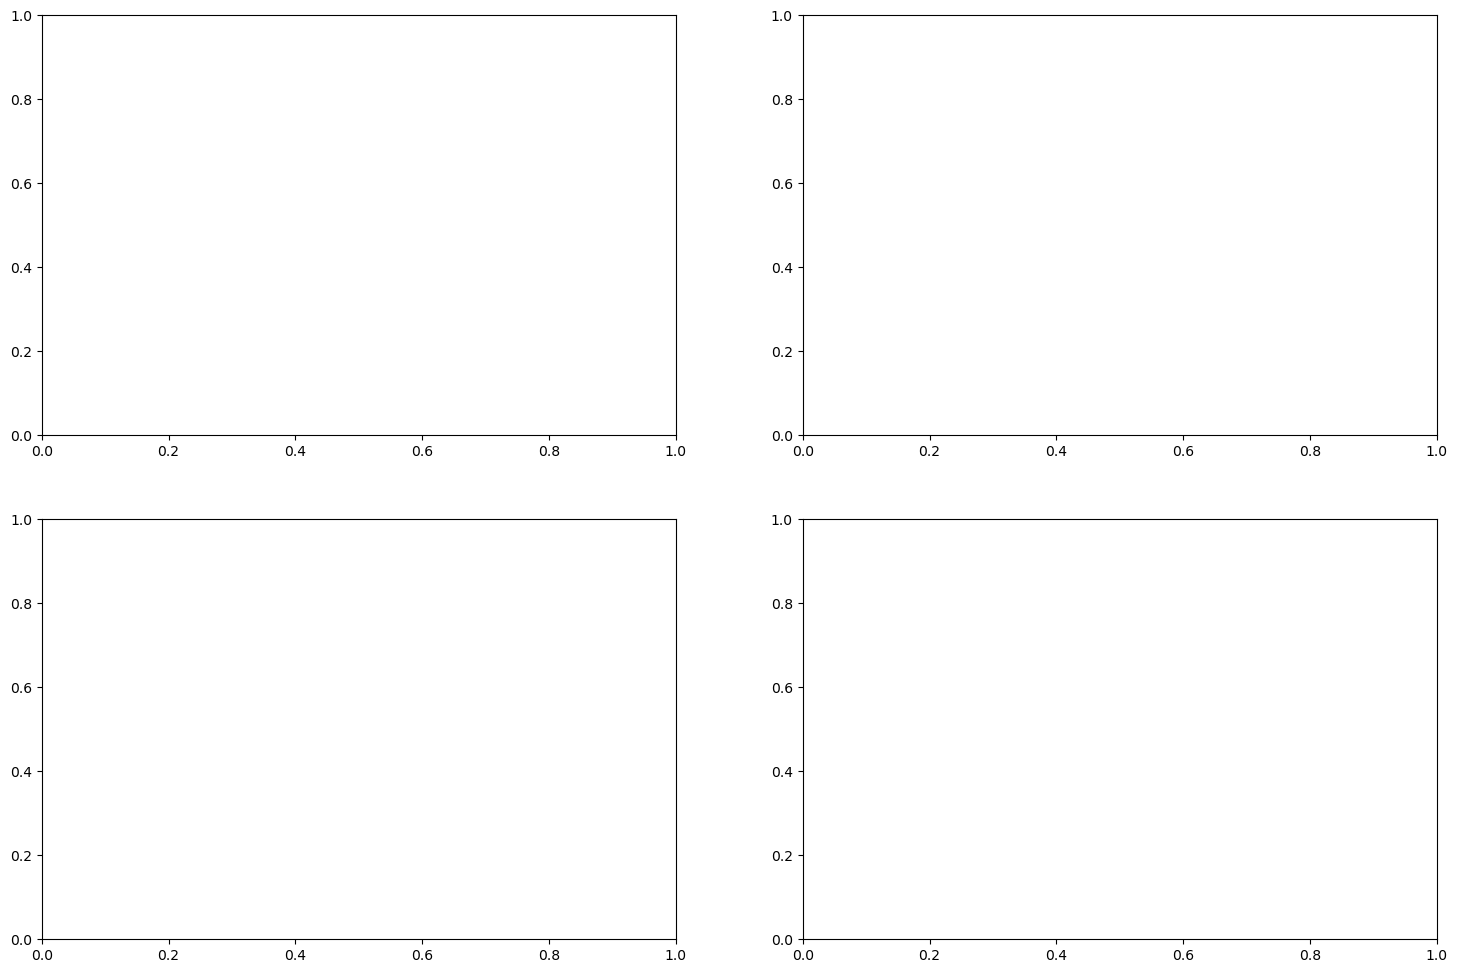

In [116]:
importlib.reload(accDerivs)
importlib.reload(importResults)
importlib.reload(importClin)


subs_to_plot = [
    '008', '009', '010', '012',
    '013', '014', '016', '017']
freqBand = 'mid-gamma'
plot_subs_diff_color = True
tasks_to_plot = ['rest', 'tap']  # 'both', 
select_contraEcogTaps = True
task = 'both'
save_plot=False
show_plot=True
figname=f'group_LID_vs_MIC_IBAGS'


# sets of freqBand ranges
freqRanges = {
    'mid-gamma': (70, 90),
    'beta': (12, 30),
    'low-beta': (12, 20),
    'high-beta': (20, 30),
    'theta': (4, 7),
    'alpha': (7, 10)
}
peak_range = freqRanges[freqBand]

# adjust filename to variables
figname += f'_{freqBand}'
if select_contraEcogTaps:
    figname += '_ecogSided'


fig, axes = plt.subplots(
    len(tasks_to_plot), 2,
    figsize=(18, len(tasks_to_plot) * 6),
)

prop_cycle = plt.rcParams['axes.prop_cycle']
std_colors = prop_cycle.by_key()['color']
std_colors = list(get_colors().values())  # adjusted colors
if len(subs_to_plot) > len(std_colors):
    raise ValueError('NOT ENOUGH COLORS SPECIFIED')

fs = 24

# find individual peak freqs
peak_i, peak_f = {}, {}
mics = {}
for t in ['both', 'rest', 'tap']: mics[t] = {}

for sub in subs_to_plot:

    mics['both'][sub] = importResults.get_mic_scores(sub, task='both')
    # get peak gamma freq
    peak_i[sub], peak_f[sub] = importResults.get_peakFreq_in_timeFreq(
        tf_values=mics['both'][sub].values,
        times=mics['both'][sub].index,
        freqs=mics['both'][sub].keys(),
        f_min=peak_range[0],
        f_max=peak_range[1],
    )
    
    mics['rest'][sub] = importResults.get_mic_scores(
        sub, task='rest', ecogSide_tapAdjust=select_contraEcogTaps,)
    mics['tap'][sub] = importResults.get_mic_scores(
        sub, task='tap', ecogSide_tapAdjust=select_contraEcogTaps,)
    


for i_t, task in enumerate(tasks_to_plot):

    ax_title = f'Max. Imag. Coh. - {task.upper()}'

    all_y_values, all_lid_scores = [], []
    y_values_sub, lid_scores_sub = {}, {}

    for s, sub in enumerate(subs_to_plot):

        lid_t, lid_y = importClin.get_cdrs_specific(
            sub=sub, side='contralat ecog', rater='Mean',
        )
        gamma_y = np.mean(
            mics[task][sub].values[:, peak_i[sub]-1:peak_i[sub]+2],
            axis=1)
        gamma_t = np.around(mics[task][sub].index / 60, 1)

        # find nearest index LID score for gamma times
        closest_lid_idx = [np.argmin(abs(lid_t - t)) for t in gamma_t]
        # get nearest LID score for gamma times
        gamma_lid = lid_y[closest_lid_idx]

        all_lid_scores.extend(gamma_lid)
        all_y_values.extend(gamma_y)
        # store values per sub for color plotting
        y_values_sub[sub] = gamma_y
        lid_scores_sub[sub] = gamma_lid
        

    # Plot Sub-Means per CDRS score
    ySubMeans_per_score = {}  # to plot means of sub-means per CDRS score
    ySubStds_per_score = {}  # to plot std of sub-means per CDRS score

    for i_sub, sub in enumerate(subs_to_plot): 
        scores_pres = np.unique(lid_scores_sub[sub])
        sub_means = np.zeros((len(scores_pres)))  # to fill with y-value-means
        sub_stds = np.zeros((len(scores_pres)))  # to fill with y-value-stds
        for i_sc, score in enumerate(scores_pres):
            # find indices for every CDRS score
            idx = np.where(np.array(lid_scores_sub[sub]) == score)[0]
            score_mean = np.mean(np.array(y_values_sub[sub])[idx])
            score_std = np.std(np.array(y_values_sub[sub])[idx])
            sub_means[i_sc] = score_mean
            sub_stds[i_sc] = score_std
            try:
                ySubMeans_per_score[score].append(score_mean)
                ySubStds_per_score[score].append(score_std)
            except KeyError:
                ySubMeans_per_score[score] = []
                ySubStds_per_score[score] = []
                ySubMeans_per_score[score].append(score_mean)
                ySubStds_per_score[score].append(score_std)

        axes[i_t, 0].plot(
            scores_pres, sub_means, color=std_colors[i_sub],
            marker='o', alpha=.5,
            # label=f'{sub} ({int(peak_f[sub])} Hz)',
            label=sub,
            )
        axes[i_t, 0].fill_between(
            x=scores_pres, y1=sub_means - sub_stds,
            y2=sub_means + sub_stds, edgecolor=None,
            color=std_colors[i_sub], alpha=.1,)
        
    # GRAND MEANS
    pres_scores = np.array(list(ySubMeans_per_score.keys()))  # get present score
    idx_sort = np.argsort(pres_scores)  # sort score lists ascending
    sorted_subMeans = np.array(
        list(ySubMeans_per_score.values()),
        dtype=object
    )[idx_sort]  # get y-sub-means per score in ascending order
    x = pres_scores[idx_sort]  # scores in ascending order
    y = [np.mean(sc_means) for sc_means in sorted_subMeans]  # means of sub-means per score in ascending order
    axes[i_t, 0].plot(x, y, lw=5, alpha=.3, ls='--', c='k',
                      label='Mean of sub-means')

    axes[i_t, 0].set_ylabel(
        f'abs. Max. Imag. Coherence\n(ind. peak [{peak_range[0]}-{peak_range[1]} Hz], a.u.)',  fontsize=fs,)
    axes[i_t, 0].set_xlabel(
        'contralat. Dyskinesia (CDRS)', fontsize=fs,)
    axes[i_t, 0].legend(frameon=False, fontsize=fs - 10, ncol=4,
        )
    axes[i_t, 0].tick_params(labelsize=fs, axis='both', size=fs)
    axes[i_t, 0].set_ylim(0, 1)
    axes[i_t, 0].set_title(ax_title, fontsize=fs + 2, fontweight='bold',)

    
    

    ## scatterplot MIC vs LID-severeness
    for sub_scat in subs_to_plot:
        np.random.seed(27)
        jitter = np.random.uniform(
            low=-.15, high=0.15,
            size=len(lid_scores_sub[sub_scat]))
        axes[i_t, 1].scatter(
            np.array(lid_scores_sub[sub_scat]) + jitter,
            y_values_sub[sub_scat],
            alpha=.5,
            # label=sub_scat,
        )
    # axes[i_t, 1].legend(frameon=False, fontsize=fs, ncol=4)
    
    axes[i_t, 1].set_ylabel(
        'abs Max Imag Coh (a.u.)', fontsize=fs,)
    axes[i_t, 1].set_xlabel(
        'contralat LID (CDRS)', fontsize=fs,)
    axes[i_t, 1].tick_params(labelsize=fs, axis='both', size=fs)
    # add GRAND MEAN statistic in title
    r, p = pearsonr(all_lid_scores, all_y_values)
    ax_title = (f"Overall Pearson's R = {np.round(r, 3)}, "
        f"(p = {np.round(p, 4)})")
    axes[i_t, 1].set_title(ax_title, fontsize=fs + 2)
    axes[i_t, 1].set_ylim(0, 1)

# plt.suptitle(
#     f'L-DOPA induced Dyskinesia vs {freqBand} Cortico-STN-Coherence\n'
#     f'(individual peak in {peak_range[0]} - {peak_range[1]} Hz)\n',
#     size=fs + 4, x=.5, y=.98)
# plt.legend(frameon=False, fontsize=fs, ncol=4,
#         bbox_to_anchor=[.1, 1.05], loc='lower left',)
plt.tight_layout()

if plot_subs_diff_color: figname += '_subCols'

if save_plot:
    plt.savefig(
        os.path.join(
            get_project_path('figures'), 'ft_exploration',
            data_version, 'mvc', 'ibags23', figname
        ),
        facecolor='w', dpi=300,
    )
if show_plot: plt.show()
else: plt.close()

## 2. Windowing for multivariate connectivity

In [ ]:
### IMPORT MULTIVARIATE CONNECTIVITY FUNCTIONS (PM: sys.path.append module)
sys.path.append(os.path.join(codepath, 'hackathon_mne_mvc'))
# import hackathon_mne_mvc as multiVarConn
from hackathon_mne_mvc.Processing.helper_functions import (
    multivar_seed_target_indices
)
from hackathon_mne_mvc.Processing.mne_wrapper_functions import (
    multivar_spectral_connectivity_epochs,
)

In [ ]:
print(vars(data.rest.sub012).keys())
print(data.rest.sub012.col_names)
print(data.rest.sub012.data_arr.shape)

dict_keys(['data_arr', 'fs', 'col_names', 'time_index', 'task_sel'])
['dopa_time' 'ECOG_R_01_02' 'ECOG_R_02_03' 'ECOG_R_03_04' 'ECOG_R_04_05'
 'task' 'LFP_L_02_03' 'LFP_L_03_04' 'LFP_L_04_02' 'LFP_L_02_05'
 'LFP_L_03_06' 'LFP_L_04_07' 'LFP_L_05_06' 'LFP_L_06_07' 'LFP_L_07_05'
 'LFP_L_05_08' 'LFP_L_06_08' 'LFP_L_07_08' 'LFP_R_01_02' 'LFP_R_01_03'
 'LFP_R_01_04' 'LFP_R_02_03' 'LFP_R_03_04' 'LFP_R_04_02' 'LFP_R_02_05'
 'LFP_R_03_06' 'LFP_R_04_07' 'LFP_R_05_06' 'LFP_R_06_07' 'LFP_R_07_05'
 'LFP_R_05_08' 'LFP_R_06_08' 'LFP_R_07_08' 'LFP_R_08_01' 'left_tap'
 'right_tap' 'left_move' 'right_move' 'no_move']
(4427776, 39)


In [ ]:
importlib.reload(utilsWindows)
# get windows within set time distances
windows12 = utilsWindows.get_windows(
    data=data.rest.sub012.data_arr,
    fs=data.rest.sub012.fs,
    winLen_sec=60,
    part_winOverlap=.5,
    col_names=data.rest.sub012.col_names,
    return_as_class=True,
)


In [ ]:
importlib.reload(utilsFiles)

<module 'utils.utils_fileManagement' from 'c:\\Users\\habetsj\\Research\\projects\\dyskinesia_neurophys\\code\\utils\\utils_fileManagement.py'>

In [ ]:
data_version = 'v3.0'
task = 'rest'
pickle_path = os.path.join(
    datapath,
    'windowed_data_classes',
    data_version,
    f'sub-{sub}',
    task,
)
pickle_name = f'{sub}_windows_{task}_{data_version}.P'

from utils.utils_windowing import windowedData
# windows = utilsFiles.load_class_pickle(
#     file_to_load=os.path.join(pickle_path, pickle_name)
# )

In [ ]:
importlib.reload(utilsWindows)
epoched_window_list = []
for win in windows12.data:

    epochs = utilsWindows.window_to_epochs(
        win_array=win,
        fs=windows12.fs,
        epochLen_sec=.5,
        remove_nan=True,
    )
    epoched_window_list.append(epochs)

In [ ]:
importlib.reload(utilsWindows)
mne_epochArr_list = utilsWindows.create_mne_epochs(
    epoched_windows=epoched_window_list,
    fs=windows12.fs,
    ch_names=windows12.keys,
    pick_only_ephys = True,
)

In [ ]:
# calculate sum PAC values per beta-phase-bin, per epoch
# make list of center-freqquencies of phase-freq-bands
pha_bins_midF, amp_bins_midF = [], []
for ph, pha in enumerate(frange_pha[:-1]):
    pha_bins_midF.append((pha + frange_pha[ph + 1]) // 2)
# same center-freq list for ampl-freq-bandw's
for ph, pha in enumerate(frange_amp[:-1]):
    amp_bins_midF.append((pha + frange_amp[ph + 1]) // 2)
# create empty dict's with lists to store PACs
pha_pacs = {}
for T in pacs.keys(): 
    pha_pacs[T] = {}
    for mov in pacs[0].keys():
        pha_pacs[T][mov] = {}
        for pha in pha_bins_midF:
            pha_pacs[T][mov][pha] = []
# store PACs in dsignated lists
# include Z-scored and raw PACs!!!
for T in pacs.keys():
    for mov in pacs[0].keys():
        for ph, pha in enumerate(pha_bins_midF):
            pha_pacs[T][mov][pha].append(
                pacs[T][mov][:, ph]
            )
        
